In [1]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import datetime as dt

import os
import sys

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from optuna.trial import TrialState

sys.path.append("/project")

from model.hydro.gr4j_prod import ProductionStorage
from model.utils.training import EarlyStopper
from model.utils.evaluation import evaluate
from model.optim.pso_np import PSO
from data.utils import read_dataset_from_file, get_station_list
from model.ml.lstm import LSTM
from model.utils.evaluation import evaluate

In [13]:
data_dir = '/data/camels/aus/'
sub_dir = 'no-scale'
station_id = '401009'
run_dir = '/project/results/hygr4j'

N_EPOCHS = 50
BATCH_SIZE = 256

INPUT_DIM = 9
X1 = 1047.4872337246686

In [14]:
def create_sequence(X, y, window_size):

        assert window_size is not None, "Window size cannot be NoneType."

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(len(X)-window_size):
            Xs.append(X[i: (i + window_size)])
            ys.append(y[i + window_size-1])

        Xs, ys = torch.stack(Xs), torch.stack(ys)

        return Xs, ys

In [15]:
print(f"Reading data for station_id: {station_id}")
train_ds, test_ds = read_dataset_from_file(data_dir, 
                                        sub_dir, 
                                        station_id=station_id)

# Get tensors from dataset
t_train, X_train, y_train = train_ds.tensors
t_test, X_test, y_test = test_ds.tensors

# Scale input tensor
X_train = torch.nan_to_num(X_train)
X_test = torch.nan_to_num(X_test)

# Scale labels
y_mu = y_train.mean(dim=0)
y_sigma = y_train.std(dim=0)
y_train = (y_train - y_mu)/y_sigma
y_test = (y_test - y_mu)/y_sigma

# Production storage
prod_store = ProductionStorage(x1=X1)

# Prod storage output
prod_out_train = prod_store(X_train, include_x=True)[0]
X_train, y_train = create_sequence(prod_out_train, y_train, window_size=4)

prod_out_test = prod_store(X_test, include_x=True)[0]
X_test, y_test = create_sequence(prod_out_test, y_test, window_size=4)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, shuffle=False)

# Create train dataset and loader
train_ds = torchdata.TensorDataset(X_train, y_train)
train_dl = torchdata.DataLoader(train_ds,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

# Create validation dataset and loader
val_ds = torchdata.TensorDataset(X_val, y_val)
val_dl = torchdata.DataLoader(val_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_ds = torchdata.TensorDataset(X_test, y_test)
test_dl = torchdata.DataLoader(test_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

Reading data for station_id: 401009


In [16]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [17]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64, step=16)
    p = trial.suggest_float("dropout", 0.2, 0.5)
    
    model = LSTM(input_dim=INPUT_DIM,
            hidden_dim=hidden_dim,
            output_dim=1,
            n_layers=n_layers,
            dropout=p)

    return model

In [18]:
def val_step(model, dl, loss_fn):
    loss_val = 0.
    model.eval()
    for j, (X, y) in enumerate(dl, start=1):
        y_hat = model(X)
        loss_val += loss_fn(y, y_hat)
    return (loss_val/j).detach()


def train_step(model, dl, loss_fn, opt):
    total_loss = 0.
    model.train()
    for i, (X, y) in enumerate(dl, start=1):
        opt.zero_grad()
        y_hat = model(X)
        loss_val = loss_fn(y, y_hat)
        total_loss += loss_val
        loss_val.backward()
        opt.step()
    return (total_loss/i).detach()

def evaluate_preds(model, ds, batch_size, x_scaler=None, y_scaler=None, plot=True):
    # Evaluate on train data
    model.eval()
    dl = torchdata.DataLoader(ds, 
                              batch_size=batch_size,
                              shuffle=False)

    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    for i, (X, y) in enumerate(dl, start=1):
        
        y_hat = model(X)

        Q.append((y*y_sigma+y_mu).detach().numpy())
        Q_hat.append((y_hat*y_sigma+y_mu).detach().numpy())
        
        X_inv = X[:, -1]*prod_store.sigma+prod_store.mu
        
        P.append((X_inv[:, 0]).detach().numpy())
        ET.append((X_inv[:, 1]).detach().numpy())
    
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q = np.concatenate(Q, axis=0).flatten()
    Q_hat = np.clip(np.concatenate(Q_hat, axis=0).flatten(), 0, None)


    return evaluate(P, ET, Q, Q_hat, plot=plot)

In [19]:
def objective(trial, return_model=False):
    # Generate the model.
    model = define_model(trial)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    opt = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Loss function
    loss_fn = nn.MSELoss()

    # Early stopping
    early_stopper = EarlyStopper(patience=10, min_delta=0.01)

    pbar = range(1, N_EPOCHS+1)

    for epoch in pbar:

        # Train step
        train_loss = train_step(model, train_dl, loss_fn, opt)

        # Validation step
        val_nse, _ = evaluate_preds(model, val_dl.dataset, 
                                    batch_size=BATCH_SIZE, plot=False)

        trial.report(val_nse, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    if return_model:
        return model
    return val_nse


In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-01-31 12:20:57,604] A new study created in memory with name: no-name-6f80a354-113d-4888-9023-e203beb8d092
[I 2023-01-31 12:21:03,153] Trial 0 finished with value: 0.6987407505512238 and parameters: {'n_layers': 1, 'hidden_dim': 16, 'dropout': 0.4851177777682522, 'optimizer': 'Adam', 'lr': 0.00424031775255147}. Best is trial 0 with value: 0.6987407505512238.
[I 2023-01-31 12:21:20,788] Trial 1 finished with value: -0.3371555805206299 and parameters: {'n_layers': 3, 'hidden_dim': 64, 'dropout': 0.32473685832286187, 'optimizer': 'SGD', 'lr': 0.00433133767283246}. Best is trial 0 with value: 0.6987407505512238.
[I 2023-01-31 12:21:31,343] Trial 2 finished with value: -1.2060906887054443 and parameters: {'n_layers': 2, 'hidden_dim': 32, 'dropout': 0.2153015653405369, 'optimizer': 'RMSprop', 'lr': 0.00013010388078537642}. Best is trial 0 with value: 0.6987407505512238.
[I 2023-01-31 12:21:38,492] Trial 3 finished with value: -1.0297472476959229 and parameters: {'n_layers': 1, 'hidden

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  79
  Number of complete trials:  21
Best trial:
  Value:  0.7074524760246277
  Params: 
    n_layers: 1
    hidden_dim: 16
    dropout: 0.38312865986981354
    optimizer: Adam
    lr: 0.004300157360686417


In [21]:
def train_model(trial):
    
    # Generate the model.
    model = define_model(trial)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    opt = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Loss function
    loss_fn = nn.MSELoss()

    # Early stopping
    early_stopper = EarlyStopper(patience=10, min_delta=0.01)

    pbar = tqdm(range(1, N_EPOCHS+1))

    for epoch in pbar:

        # Train step
        train_loss = train_step(model, train_dl, loss_fn, opt)

        # Train step
        val_loss = val_step(model, val_dl, loss_fn)

        pbar.set_description(f"""Epoch {epoch} loss: {train_loss.numpy():.4f} val_loss: {val_loss.numpy():.4f}""")

        if early_stopper.early_stop(val_loss):
            break
    
    return model


In [22]:
N_EPOCHS = 200
model = train_model(trial)

Epoch 45 loss: 0.2521 val_loss: 0.1319:  22%|██▏       | 44/200 [00:04<00:16,  9.51it/s]


(0.6547927260398865, 0.7433798637262281, <Figure size 1600x600 with 1 Axes>)

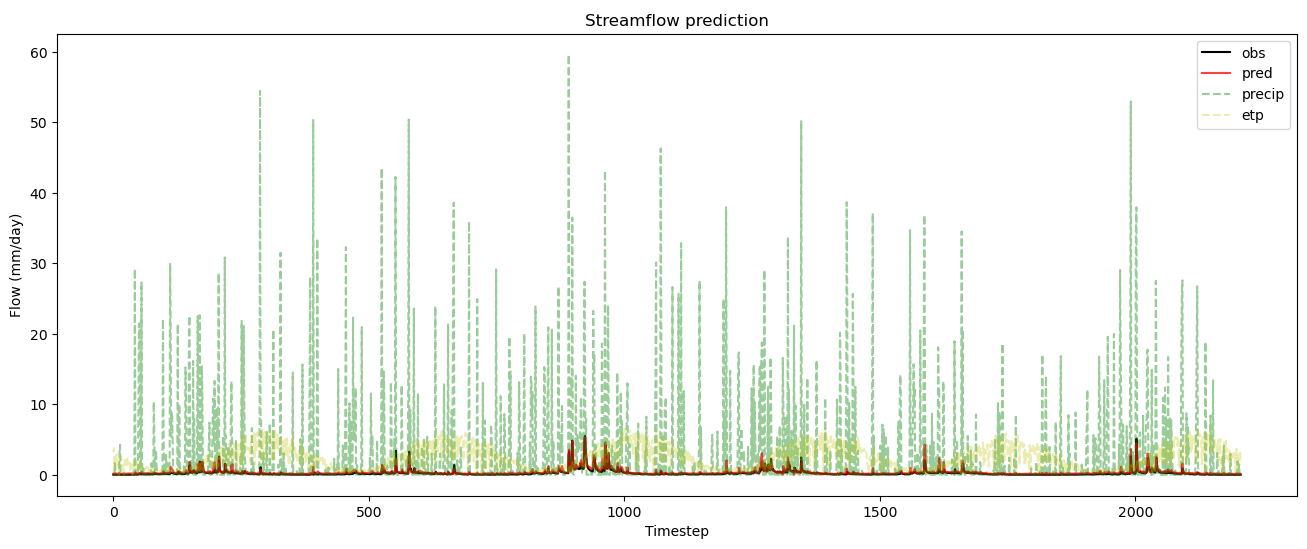

In [25]:
evaluate_preds(model, val_ds, batch_size=BATCH_SIZE)

(0.44793570041656494, 0.6443032033327447, <Figure size 1600x600 with 1 Axes>)

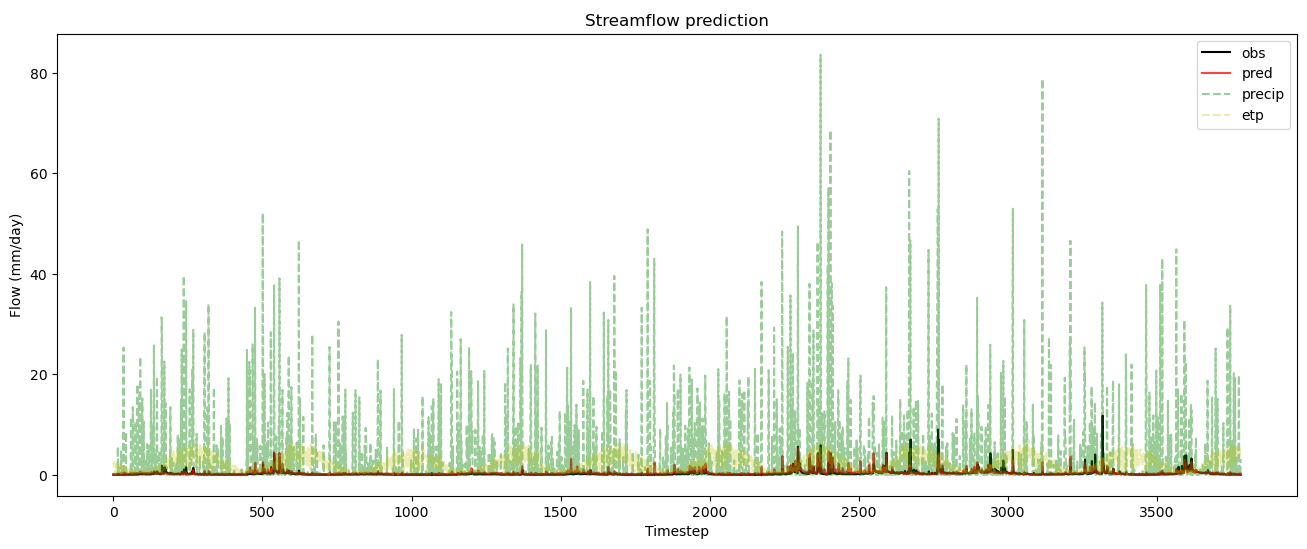

In [23]:
evaluate_preds(model, test_ds, batch_size=BATCH_SIZE)